## This example demonstrates inversion for the scattering potential with Born modelling, commonly known as imaging or migration. ##

## The code is very similar to that used in the FWI example. We load the Marmousi 1 velocity model and smooth it to use as the migration velocity model, load the data generated in the forward modelling example, and then perform interative optimisation, repeatedly running forward modelling and backpropagation to calculate the gradients and update our model. The main differences are that now we use the Born propagator and we invert for the scattering model rather than the velocity.



## Let’s focus on these changes.

In [1]:
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar, scalar_born

In [2]:
device = torch.device('cuda' if torch.cuda.is_available()
                      else 'cpu')
ny = 2301
nx = 751
dx = 4.0
v_true = torch.from_file('marmousi_vp.bin',
                         size=ny*nx).reshape(ny, nx)

In [3]:
# Select portion of model for inversion
ny = 600
nx = 250
v_true = v_true[:ny, :nx]

# Smooth to use as starting model
v_mig = (torch.tensor(1/gaussian_filter(1/v_true.numpy(), 5))
          .to(device))

In [4]:
n_shots = 115

n_sources_per_shot = 1
d_source = 20  # 20 * 4m = 80m
first_source = 10  # 10 * 4m = 40m
source_depth = 2  # 2 * 4m = 8m

n_receivers_per_shot = 384
d_receiver = 6  # 6 * 4m = 24m
first_receiver = 0  # 0 * 4m = 0m
receiver_depth = 2  # 2 * 4m = 8m

freq = 25
nt = 750
dt = 0.004
peak_time = 1.5 / freq

In [5]:
observed_data = (
    torch.from_file('marmousi_data.bin',
                    size=n_shots*n_receivers_per_shot*nt)
    .reshape(n_shots, n_receivers_per_shot, nt)
)

# Select portion of data for inversion
n_shots = 20
n_receivers_per_shot = 100
nt = 300
observed_data = (
    observed_data[:n_shots, :n_receivers_per_shot, :nt].to(device)
)

In [6]:
# source_locations
source_locations = torch.zeros(n_shots, n_sources_per_shot, 2,
                               dtype=torch.long, device=device)
source_locations[..., 1] = source_depth
source_locations[:, 0, 0] = (torch.arange(n_shots) * d_source +
                             first_source)

# receiver_locations
receiver_locations = torch.zeros(n_shots, n_receivers_per_shot, 2,
                                 dtype=torch.long, device=device)
receiver_locations[..., 1] = receiver_depth
receiver_locations[:, :, 0] = (
    (torch.arange(n_receivers_per_shot) * d_receiver +
     first_receiver)
    .repeat(n_shots, 1)
)

# source_amplitudes
source_amplitudes = (
    (deepwave.wavelets.ricker(freq, nt, dt, peak_time))
    .repeat(n_shots, n_sources_per_shot, 1).to(device)
)

## Born modelling propagates a wavefield in a “background” velocity model. This wavefield interacts with a provided scattering potential at each time step to produce a source term for a second wavefield. This second wavefield, the scattered wavefield, is also propagated using the background velocity model, and it is from this scattered wavefield that receivers record their data. The recorded data will therefore only contain singly-scattered waves, while the observed dataset also contains strong direct arrivals. Trying to get Born modelling to match these direct arrivals would cause strong artefacts. There are multiple ways to handle this. The one we will use in this example is to model these direct arrivals by forward modelling through our smooth migration velocity model using the regular (non-Born) propagator and then subtract them from the observed dataset before we use it in inversion:

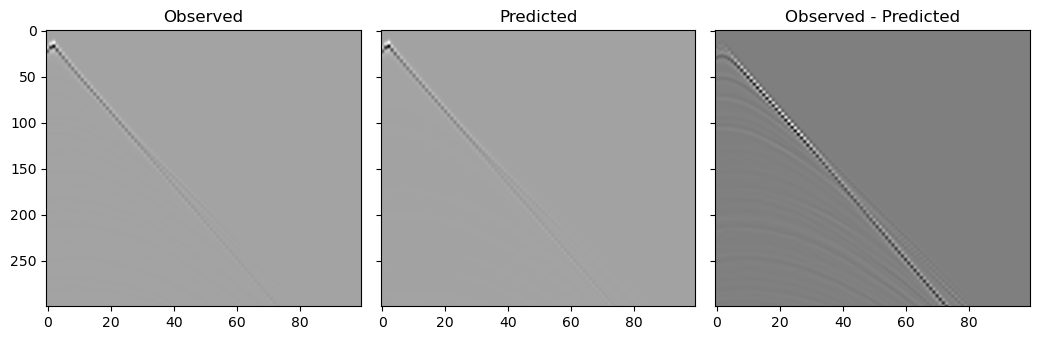

In [7]:
# Estimate direct arrival by forward modelling through
# migration velocity model, and then subtract it from
# the observed data. We set max_vel to be the maximum
# velocity in the true velocity model so that Deepwave's
# internal time step size will be the same as when the
# observed dataset was created, to get a better match.
out = scalar(
    v_mig, dx, dt,
    source_amplitudes=source_amplitudes,
    source_locations=source_locations,
    receiver_locations=receiver_locations,
    pml_freq=freq,
    accuracy=8,
    max_vel=v_true.max(),
)
observed_scattered_data = observed_data - out[-1]

_, ax = plt.subplots(1, 3, figsize=(10.5, 3.5), sharex=True,
                     sharey=True)
ax[0].imshow(observed_data[0].cpu().T, aspect='auto', cmap='gray')
ax[0].set_title("Observed")
ax[1].imshow(out[-1][0].cpu().T, aspect='auto', cmap='gray')
ax[1].set_title("Predicted")
ax[2].imshow(observed_scattered_data[0].cpu().T, aspect='auto',
             cmap='gray')
ax[2].set_title("Observed - Predicted")
plt.tight_layout()
plt.savefig('example_lsrtm_scattered.jpg')

## Note that we specified the max_vel parameter to be the maximum velocity in the true velocity model. This will cause Deepwave’s internal time step size to be the same as when observed_data was created, to get a better match between the two datasets (and so fuller cancellation of the direct arrivals). From the results we see that subtracting this estimate of the direct arrivals successfully attenuates them relative to the scattered arrivals.

## We now run the optimisation to invert for the scattering potential. To do this we create an initial scattering model (which is all zeros), specify that gradients will need to be calculated with respect to it, and then iteratively optimise it so that the output of Born propagation matches the observed scattered data:

In [8]:
# Create scattering amplitude that we will invert for
scatter = torch.zeros_like(v_mig)
scatter.requires_grad_()

# Setup optimiser to perform inversion
optimiser = torch.optim.LBFGS([scatter])
loss_fn = torch.nn.MSELoss()

# Run optimisation/inversion
n_epochs = 3

for epoch in range(n_epochs):
    def closure():
        optimiser.zero_grad()
        out = scalar_born(
            v_mig, scatter, dx, dt,
            source_amplitudes=source_amplitudes,
            source_locations=source_locations,
            receiver_locations=receiver_locations,
            pml_freq=freq,
        )
        loss = 1e6 * loss_fn(out[-1], observed_scattered_data)
        loss.backward()
        return loss.item()

    optimiser.step(closure)

## This produces the following image (note again that the result is worse on the right because there are no sources there).

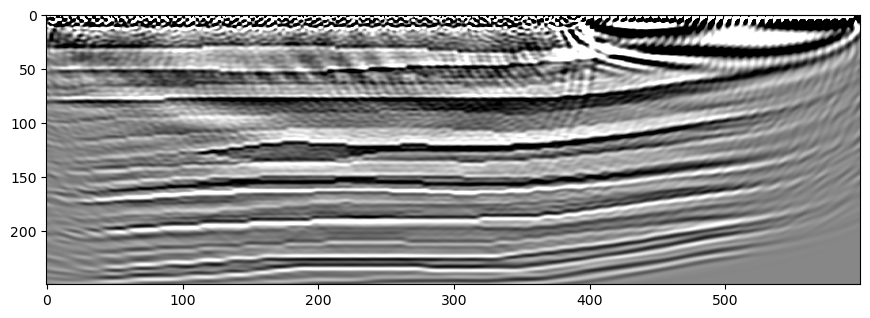

In [9]:
# Plot
vmin, vmax = torch.quantile(scatter.detach(),
                            torch.tensor([0.05, 0.95]).to(device))
plt.figure(figsize=(10.5, 3.5))
plt.imshow(scatter.detach().cpu().T, aspect='auto', cmap='gray',
           vmin=vmin, vmax=vmax)
plt.savefig('example_lsrtm.jpg')